In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import pandas as pd

warnings.filterwarnings("ignore")

**Dataset and descriptions**

The data is numerical, time-series financial dataset. It's daily market level data used to predict future market returns.

Link to dataset - https://www.kaggle.com/competitions/hull-tactical-market-prediction/data?select=train.csv

In [19]:
df = pd.read_csv("train.csv", parse_dates=True, low_memory=False)
print("Training dataset shape:", df.shape)
df.head()

Training dataset shape: (9021, 98)


,date_id,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V3,V4,V5,V6,V7,V8,V9,forward_returns,risk_free_rate,market_forward_excess_returns
0,0,0,0,0,1,1,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002421,0.000301,-0.003038
1,1,0,0,0,1,1,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.008495,0.000303,-0.009114
2,2,0,0,0,1,0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.009624,0.000301,-0.010243
3,3,0,0,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004662,0.000299,0.004046
4,4,0,0,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.011686,0.000299,-0.012301


In [7]:
df = pd.read_csv("test.csv", parse_dates=True, low_memory=False)
print("Test dataset shape:", df.shape)
df.head()

Test dataset shape: (10, 99)


,date_id,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V4,V5,V6,V7,V8,V9,is_scored,lagged_forward_returns,lagged_risk_free_rate,lagged_market_forward_excess_returns
0,8980,0,0,0,0,1,0,0,1,0,...,0.828042,0.999172,0.759921,-0.803127,0.170966,-0.751909,True,0.003541,0.000161,0.003068
1,8981,0,0,0,0,1,0,0,1,0,...,0.831349,1.120336,0.556217,-0.686192,0.141865,-0.660326,True,-0.005964,0.000162,-0.006437
2,8982,0,0,0,0,1,0,0,0,1,...,0.832672,1.088992,0.665344,-0.459367,0.199405,-0.510979,True,-0.007410,0.000160,-0.007882
3,8983,0,0,0,0,1,0,0,0,1,...,0.835979,1.040988,0.594577,-0.561643,0.161706,-0.575997,True,0.005420,0.000160,0.004949
4,8984,0,0,0,0,0,0,1,0,1,...,0.839947,0.944593,0.715608,-0.692649,0.124669,-0.654045,True,0.008357,0.000159,0.007887


In [12]:
dtypes = df.dtypes
num_cols = dtypes[dtypes != 'object'].index.tolist()
cat_cols = dtypes[dtypes == 'object'].index.tolist()
print("numeric:", len(num_cols), "categorical:", len(cat_cols))
print("numeric sample:", num_cols[:10])
print("categorical sample:", cat_cols[:10])

# We can see here that all the features are numeric, and none are categorical


numeric: 99 categorical: 0
numeric sample: ['date_id', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9']
categorical sample: []


In [13]:
descr = df.describe().T
descr['missing'] = df.isna().sum()
descr['unique'] = df.nunique()
descr.head(30)

,count,mean,std,min,25%,50%,75%,max,missing,unique
date_id,10.0,8984.500000,3.027650,8980.000000,8982.250000,8984.500000,8986.750000,8989.000000,0,10
D1,10.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,1
D2,10.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,1
D3,10.0,0.100000,0.316228,0.000000,0.000000,0.000000,0.000000,1.000000,0,2
D4,10.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,1
D5,10.0,0.400000,0.516398,0.000000,0.000000,0.000000,1.000000,1.000000,0,2
D6,10.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,1
D7,10.0,0.100000,0.316228,0.000000,0.000000,0.000000,0.000000,1.000000,0,2
D8,10.0,0.200000,0.421637,0.000000,0.000000,0.000000,0.000000,1.000000,0,2
D9,10.0,0.300000,0.483046,0.000000,0.000000,0.000000,0.750000,1.000000,0,2


In [16]:
missing = df.isna().sum()
missing = missing[missing>0].sort_values(ascending=False)
print(missing.head(40))


# We can see that there are no missing values


Series([], dtype: int64)


**Data preprocessing**

Top 10 most positively correlated features:
Index(['market_forward_excess_returns', 'forward_returns_roll5', 'E8_lag4',
       'M3_lag5', 'E8_lag1', 'P2', 'M3', 'P2_lag2', 'V13', 'E8_lag5'],
      dtype='object')


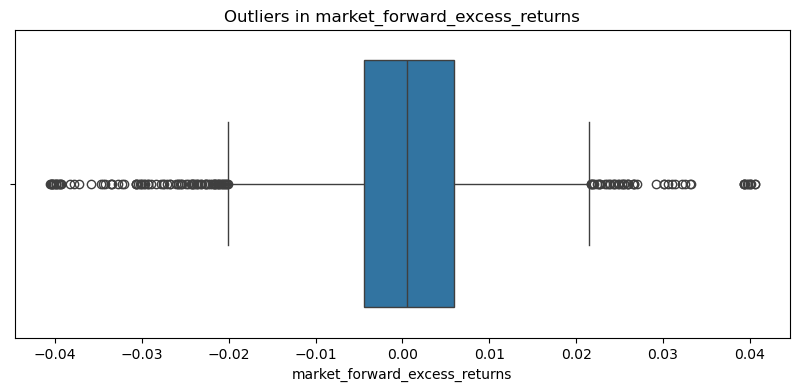

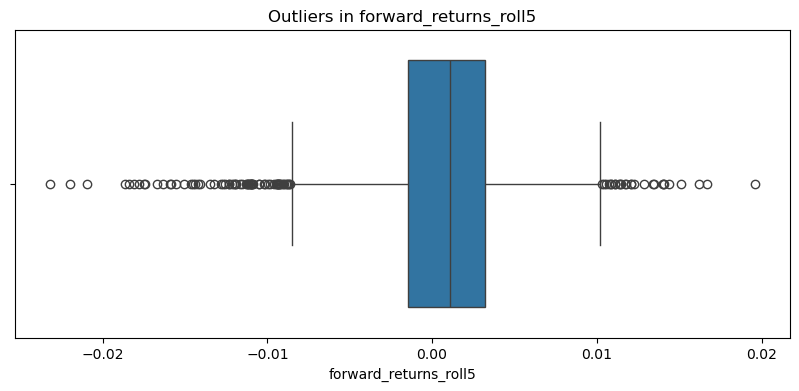

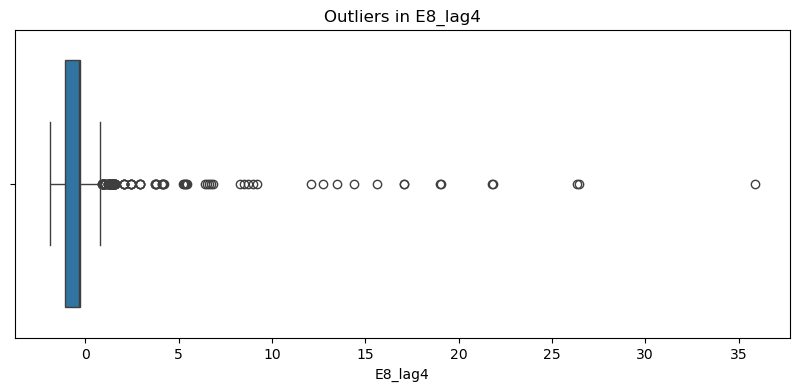

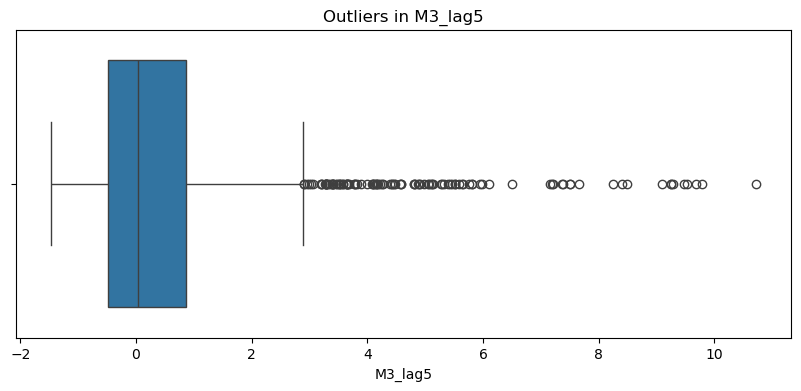

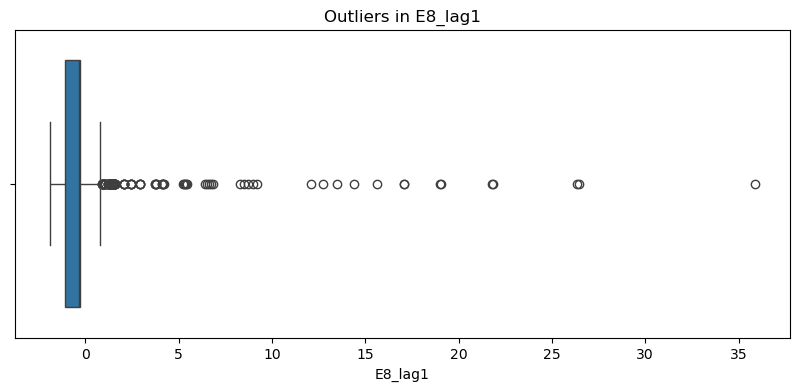

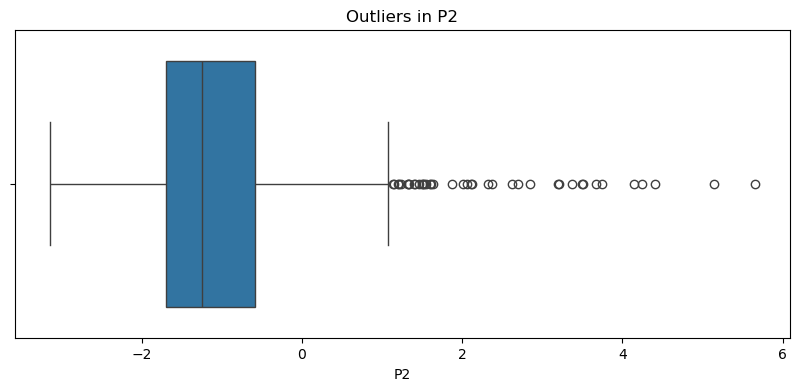

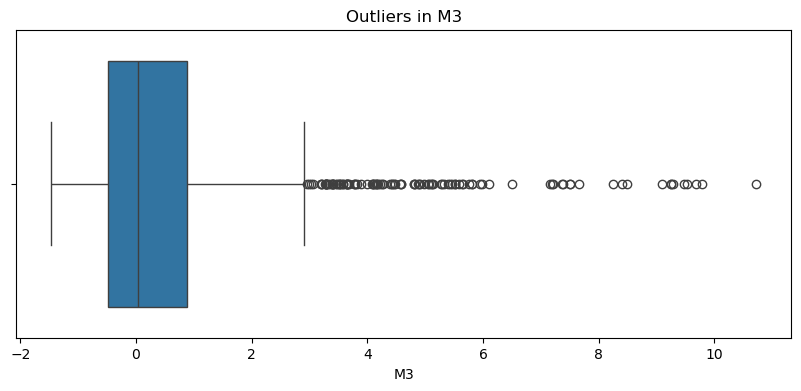

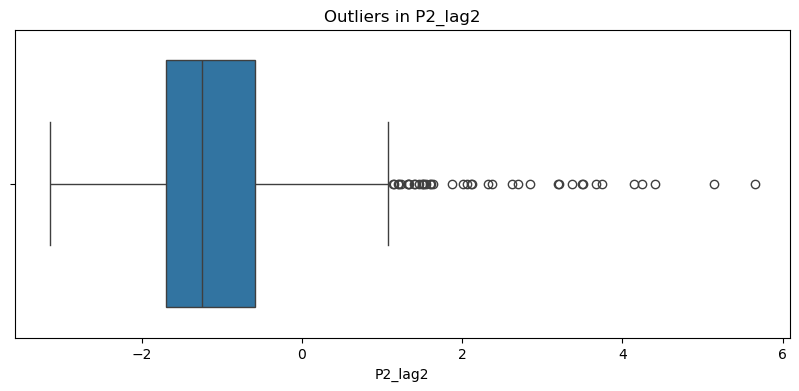

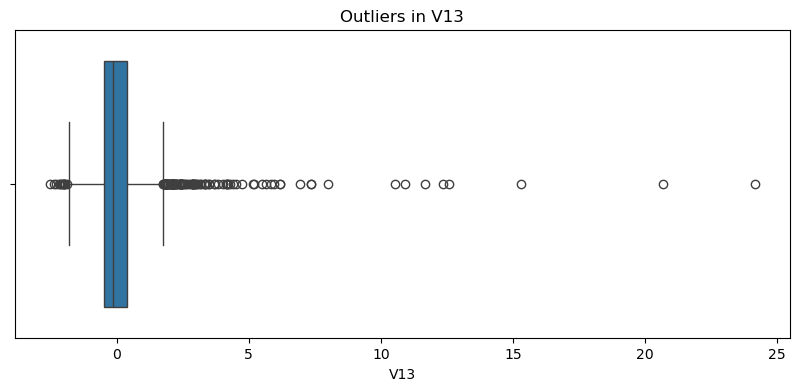

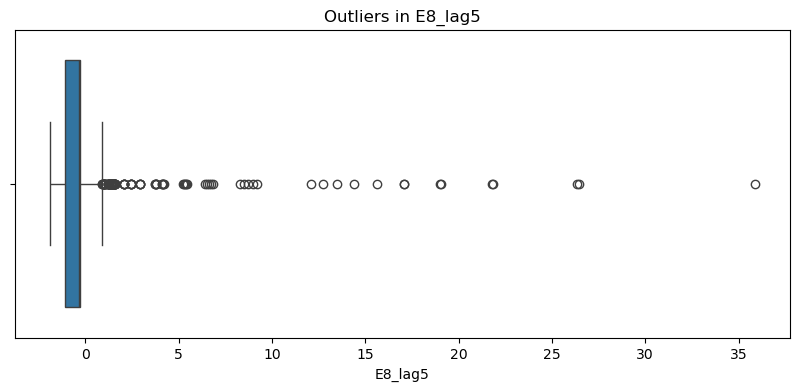

In [47]:
numeric_cols = train.select_dtypes(include='number').columns
correlations = train[numeric_cols].corr()['forward_returns'].sort_values(ascending=False)


top_10_cols = correlations.index[1:11]   

print("Top 10 most positively correlated features:")
print(top_10_cols)

# Plot outliers for each column (boxplot)
for col in top_10_cols:
    plt.figure(figsize=(10,4))
    sns.boxplot(x=train[col])
    plt.title(f"Outliers in {col}")
    plt.show()


**Data preprocessing**

In [28]:
train.fillna(method='ffill', inplace=True)
test.fillna(method='ffill', inplace=True)

In [29]:
lag_features = ['forward_returns'] + [c for c in train.columns if c.startswith(('M','E','I','P','V','S','MOM'))]

for feature in lag_features:
    for lag in range(1,6):
        train[f'{feature}_lag{lag}'] = train[feature].shift(lag)


In [30]:
for feature in lag_features:
    train[f'{feature}_roll5'] = train[feature].rolling(5).mean()
    train[f'{feature}_roll5_std'] = train[feature].rolling(5).std()


In [31]:
train = train.dropna()

In [32]:
X = train.drop(columns=['forward_returns', 'risk_free_rate', 'market_forward_excess_returns', 'date_id'])
y = train['forward_returns']

tscv = TimeSeriesSplit(n_splits=5)

In [8]:
import lightgbm as lgb

models = []

for train_index, val_index in tscv.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)
    
    model = lgb.train(
        params={
            'objective': 'regression',
            'metric': 'rmse',
            'learning_rate': 0.01,
            'num_leaves': 31,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            'bagging_freq': 5,
            'seed': 42
        },
        train_set=lgb_train,
        num_boost_round=5000,
        valid_sets=[lgb_val],
        callbacks=[lgb.early_stopping(stopping_rounds=100)]
    )
    
    models.append(model)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74584
[LightGBM] [Info] Number of data points in the train set: 342, number of used features: 692
[LightGBM] [Info] Start training from score 0.000274
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

In [33]:
# Use the same lag and rolling feature transformations
lag_features = ['forward_returns'] + [c for c in train.columns if c.startswith(('M','E','I','P','V','S','MOM'))]

for feature in lag_features:
    for lag in range(1,6):
        if feature in test.columns:
            test[f'{feature}_lag{lag}'] = test[feature].shift(lag)
            
for feature in lag_features:
    if feature in test.columns:
        test[f'{feature}_roll5'] = test[feature].rolling(5).mean()
        test[f'{feature}_roll5_std'] = test[feature].rolling(5).std()

X_test = test.drop(columns=[
    'date_id', 'is_scored', 'lagged_forward_returns',
    'lagged_risk_free_rate', 'lagged_market_forward_excess_returns'
])

X_test = X_test.ffill().bfill()


In [34]:
X_train_cols = X.columns  # columns from training
X_test = X_test.reindex(columns=X_train_cols, fill_value=0)  # add missing columns with 0

preds = np.mean([model.predict(X_test) for model in models], axis=0)

In [35]:
# Simple linear mapping with clipping
alloc = np.clip(1 + 10 * preds, 0, 2)  # scale predicted returns

# Optional: smooth allocations
alloc = pd.Series(alloc).rolling(3, min_periods=1).mean().values


In [36]:
submission = pd.DataFrame({
    'date_id': test['date_id'],
    'allocation': alloc
})

submission.to_csv('submission.csv', index=False)

In [37]:
portfolio_returns = submission['allocation'] * test['lagged_forward_returns']
sharpe_ratio = portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(252)
print('Backtested Sharpe Ratio:', sharpe_ratio)

Backtested Sharpe Ratio: 4.898918589934113
